# Analysis of recent coronavirus data for different countries and regions.  
### Updated on March 20  
Author: Javier Moldon  
More info in https://github.com/jmoldon/coronavirus_analysis  
link to this report: https://jmoldon.github.io/coronavirus_analysis/cvid_report.html

In [10]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
import datetime
import matplotlib.dates as mdates
from IPython.display import display, Markdown


In [11]:
matplotlib.rcParams["figure.figsize"] = 12,8
import warnings
warnings.filterwarnings('ignore')
do_debug = False

# General statistics

Data comes from Johns Hopkins University at https://github.com/CSSEGISandData/COVID-19 that is updated daily.

In [12]:
# import data from github url, url1 -Confirmed, url2 -Deaths. url3 -Recovered
if True:
    filetags = ['Confirmed', 'Deaths', 'Recovered']
    for filetag in filetags:
        url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-'+filetag+'.csv'
        filename = os.path.basename(url)
        command1 = f'curl -o {filename} {url}'
        print(command1)
        os.system(command1)
        os.system(f'mv {filename} ./data/')

data_path = './data/'
file1 = data_path + 'time_series_19-covid-Confirmed.csv'
file2 = data_path + 'time_series_19-covid-Deaths.csv'
file3 = data_path + 'time_series_19-covid-Recovered.csv'

df1 = pd.read_csv(file1, error_bad_lines=False)
df2 = pd.read_csv(file2, error_bad_lines=False)
df3 = pd.read_csv(file3, error_bad_lines=False)

#display(df1.head(), df2.head(), df3.head())

curl -o time_series_19-covid-Confirmed.csv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv
curl -o time_series_19-covid-Deaths.csv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv
curl -o time_series_19-covid-Recovered.csv https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv


In [13]:
# Convert date columns to a time series
df1u = pd.melt(df1, id_vars=['Province/State', 'Country/Region', 'Lat','Long'], var_name='DateTime', value_name='Confirmed')
df2u = pd.melt(df2, id_vars=['Province/State', 'Country/Region', 'Lat','Long'], var_name='DateTime', value_name='Deaths')
df3u = pd.melt(df3, id_vars=['Province/State', 'Country/Region', 'Lat','Long'], var_name='DateTime', value_name='Recovered')

df1u['DateTime'] = pd.to_datetime(df1u['DateTime'])
df2u['DateTime'] = pd.to_datetime(df2u['DateTime'])
df3u['DateTime'] = pd.to_datetime(df3u['DateTime'])

data = pd.concat([df1u, df2u, df3u], axis=1, join='inner')
data = data.loc[:,~data.columns.duplicated()] # Remove columns that were repeated in the three datasets
data['Active'] = data['Confirmed']-data['Deaths']-data['Recovered']
data['mortality_fraction'] = data['Deaths']/data['Confirmed']
data['Province/State'][data['Province/State'].isna()] = ''

In [14]:
#Example table:
#data[['Country/Region','Confirmed','Deaths','Recovered']]

In [15]:
#I need to remove a few points manually that I identified as bad ones
data.drop(data[(data['Country/Region']=='Spain') & (data['DateTime'] == datetime.datetime.strptime('2020-03-12', '%Y-%m-%d'))].index, inplace=True)
data.drop(data[(data['Country/Region']=='Italy') & (data['DateTime'] == datetime.datetime.strptime('2020-03-12', '%Y-%m-%d'))].index, inplace=True)
data.drop(data[(data['Country/Region']=='Netherlands') & (data['DateTime'] == datetime.datetime.strptime('2020-03-12', '%Y-%m-%d'))].index, inplace=True)
data.drop(data[(data['Country/Region']=='United Kingdom') & (data['Province/State']=='United Kingdom') & (data['DateTime'] == datetime.datetime.strptime('2020-03-12', '%Y-%m-%d'))].index, inplace=True)
data.drop(data[(data['Country/Region']=='United Kingdom') & (data['Province/State']=='United Kingdom') & (data['DateTime'] == datetime.datetime.strptime('2020-03-13', '%Y-%m-%d'))].index, inplace=True)
data.drop(data[(data['Country/Region']=='United Kingdom') & (data['Province/State']=='United Kingdom') & (data['DateTime'] == datetime.datetime.strptime('2020-03-15', '%Y-%m-%d'))].index, inplace=True)

## List of most affected countries (sorted by number of confirmed cases)

In [16]:
most_cases = data.groupby(['Country/Region', 'Province/State'])[['Confirmed', 'Deaths', 'Recovered']].max().sort_values(by='Confirmed')[::-1][0:20]
most_cases

,,Confirmed,Deaths,Recovered
Country/Region,Province/State,,,
China,Hubei,67800,3130,57682
Italy,,41035,3405,4440
Iran,,18407,1284,5710
Spain,,17963,830,1107
Germany,,15320,44,113
France,France,10871,243,12
"Korea, South",,8565,91,1540
US,New York,5365,34,0
Switzerland,,4075,41,15


## List of most affected countries/provinces (sorted by number of deaths)

In [17]:
most_deaths = data.groupby(['Country/Region', 'Province/State'])[['Confirmed', 'Deaths', 'Recovered']].max().sort_values(by='Deaths')[::-1][0:20]
most_deaths

,,Confirmed,Deaths,Recovered
Country/Region,Province/State,,,
Italy,,41035,3405,4440
China,Hubei,67800,3130,57682
Iran,,18407,1284,5710
Spain,,17963,830,1107
France,France,10871,243,12
United Kingdom,United Kingdom,2689,137,65
"Korea, South",,8565,91,1540
Netherlands,Netherlands,2460,76,2
US,Washington,1376,74,1


In [18]:
def select_country(data, country='', province='', start_date='2020-01-01', end_date='2021-12-31'):
    # Select by country
    if country != '':
        cond1 = data['Country/Region'] == country
    else:
        cond1 = data['Country/Region'].notna()  # Select any country
    # Select by province
    if province != '':
        cond2 = data['Province/State'] == province
    else:
        cond2 = data['Province/State'] != np.nan  # Select any province
    # Select by time range
    if start_date != '':
        t0 = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    else:
        t0 = datetime.datetime.strptime('2000-01-01', '%Y-%m-%d')
    if end_date != '':
        t1 = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    else:
        t1 = datetime.datetime.strptime('9999-01-01', '%Y-%m-%d')
    cond3 = (data['DateTime'] >= t0) & (data['DateTime'] < t1)
    selection = cond1&cond2&cond3
    if do_debug:
        print('Number of entries per country: {}'.format(cond1.sum()))
        print('Number of entries per province: {}'.format(cond2.sum()))
        print('Number of entries per time range: {}'.format(cond3.sum()))
        print('Number of entries selected: {}'.format(selection.sum()))
    return data[selection]

# Global situation
These plots show the importance of rapid response and efficient control measures of infected people in China. Except for Hubei region, where the expansion of the virus was managed too late, the other regions have a very reduced number of Deaths in total. The other countries, especially in Europe, even with a month for preparation, shows very high infection and death rates.

### Confirmed Cases

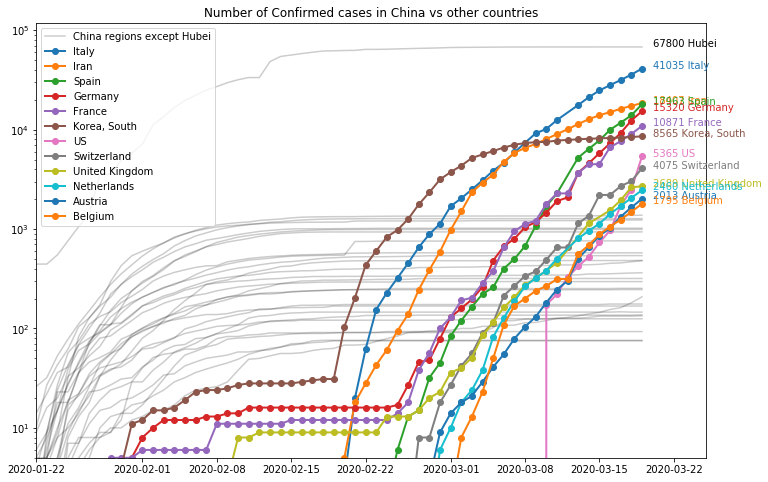

In [19]:
display(Markdown('### Confirmed Cases'))
idx = data.groupby(['Country/Region', 'Province/State'])[['Confirmed','Deaths']].sum().sort_values(by='Deaths')[::-1][0:100].index
for i in idx:
    country, province = i
    if country == 'China':# and province != 'Hubei':
        my_country = select_country(data, country=country,province=province, start_date='2020-01-22')
        if province == 'Hubei':
            l = plt.plot(my_country['DateTime'], my_country['Confirmed'], '-k', alpha=0.2, label='China regions except Hubei')
            plt.annotate(f"{my_country['Confirmed'].iloc[-1]} {province}",
                           (my_country['DateTime'].iloc[-1]+datetime.timedelta(days=1), my_country['Confirmed'].iloc[-1]), color=l[0].get_color()) 
        else:
            plt.plot(my_country['DateTime'], my_country['Confirmed'], '-k', alpha=0.2)
        


for (c,p) in most_cases.index[:13]:
    if c!='China':
        my_country = select_country(data, country=c,province=p, start_date='2020-01-22')
        l = plt.plot(my_country['DateTime'], my_country['Confirmed'], '-o', label=c, lw=2)
        plt.annotate(f"{my_country['Confirmed'].iloc[-1]} {c}",
                     (my_country['DateTime'].iloc[-1]+datetime.timedelta(days=1), my_country['Confirmed'].iloc[-1]), color=l[0].get_color())

plt.legend()
plt.gca().set_yscale('log')
plt.ylim(5, )
plt.xlim(my_country['DateTime'].iloc[0], my_country['DateTime'].iloc[-1]+datetime.timedelta(days=6))
plt.title('Number of Confirmed cases in China vs other countries');
plt.savefig(f'./plots/most_cases_evolution.png', bbox_inches='tight', dpi=100)

### Deaths

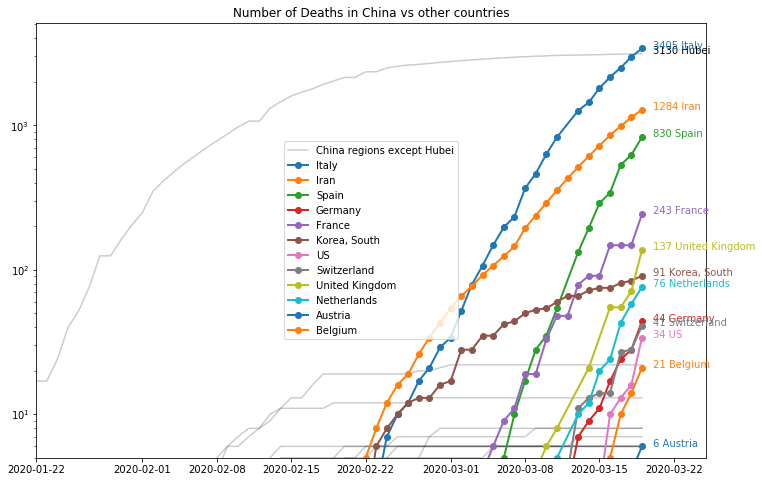

In [20]:
display(Markdown('### Deaths'))
idx = data.groupby(['Country/Region', 'Province/State'])[['Confirmed','Deaths']].sum().sort_values(by='Deaths')[::-1][0:100].index
for i in idx:
    country, province = i
    if country == 'China':# and province != 'Hubei':
        my_country = select_country(data, country=country,province=province, start_date='2020-01-22')
        if province == 'Hubei':
            l = plt.plot(my_country['DateTime'], my_country['Deaths'], '-k', alpha=0.2, label='China regions except Hubei')
            plt.annotate(f"{my_country['Deaths'].iloc[-1]} {province}",
                           (my_country['DateTime'].iloc[-1]+datetime.timedelta(days=1), my_country['Deaths'].iloc[-1]), color=l[0].get_color()) 
        else:
            plt.plot(my_country['DateTime'], my_country['Deaths'], '-k', alpha=0.2)
        


for (c,p) in most_cases.index[:13]:
    if c!='China':
        my_country = select_country(data, country=c,province=p, start_date='2020-01-22')
        l = plt.plot(my_country['DateTime'], my_country['Deaths'], '-o', label=c, lw=2)
        plt.annotate(f"{my_country['Deaths'].iloc[-1]} {c}",
                     (my_country['DateTime'].iloc[-1]+datetime.timedelta(days=1), my_country['Deaths'].iloc[-1]), color=l[0].get_color())

plt.legend()
plt.gca().set_yscale('log')
plt.ylim(5, )
plt.xlim(my_country['DateTime'].iloc[0], my_country['DateTime'].iloc[-1]+datetime.timedelta(days=6))
plt.title('Number of Deaths in China vs other countries');
plt.savefig(f'./plots/most_deaths_evolution.png', bbox_inches='tight', dpi=100)

# Evolution of cases (Confirmed, Deaths, Active and Recovery) per country

All plots have the same information. Left: log scale, right: linear scale. Bottom-right: is a zoom to show the correct scale for deaths. The straight line is a fit to a logistic growth when possible. If the fit does not converge (low number of points in early stages) a simple exponential is used. The dashed line is a prediction based on the fit. 

In [21]:
def plot_country(data_country, prediction):
    gridsize = (3, 2)
    fig = plt.figure(figsize=(16, 8))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=3)
    ax2 = plt.subplot2grid(gridsize, (0, 1), rowspan=2)
    ax3 = plt.subplot2grid(gridsize, (2, 1))
    plt.subplots_adjust(hspace=0)

    colors = {'Confirmed': '#3498db',
              'Deaths': 'tomato',
              'Recovered': 'g',
               'Active': 'k'}
    for ax in [ax1,ax2,ax3]:
        ax.plot(data_country['DateTime'], data_country['Confirmed'], 'o', color=colors['Confirmed'], label='Confirmed')
        ax.plot(data_country['DateTime'], data_country['Deaths'],    'o', color=colors['Deaths'], label='Deaths')
        ax.plot(data_country['DateTime'], data_country['Recovered'], 'o', color=colors['Recovered'], label='Recovered')
        ax.plot(data_country['DateTime'], data_country['Active'],    'o', color=colors['Active'], label='Active')    
        ax.plot(data_country['DateTime'], data_country['Recovered_fit'], '-', color=colors['Recovered'])
        ax.plot(data_country['DateTime'], data_country['Confirmed_fit'], '-', color=colors['Confirmed'])
        ax.plot(data_country['DateTime'], data_country['Deaths_fit'],    '-', color=colors['Deaths'])
        # Model and prediction
        for column in ['Confirmed', 'Deaths', 'Recovered']:
            ax.plot(prediction['DateTime'], prediction[column+'_pred'], '--', color=colors[column])
            ax.fill_between(prediction['DateTime'], prediction[column+'_pred_upper'], prediction[column+'_pred_lower'], color=colors[column], alpha=0.3)
    # Active
    active_fit = data_country['Confirmed_fit']-data_country['Recovered_fit']-data_country['Deaths_fit']
    active_pred = prediction['Confirmed_pred']-prediction['Recovered_pred']-prediction['Deaths_pred']    
    for ax in [ax1,ax2,ax3]:
        ax.plot(data_country['DateTime'], active_fit,                '-', color=colors['Active'])    
        ax.plot(prediction['DateTime'], active_pred, '--', color=colors['Active'])

    ax3.set_ylim(0, np.max(data_country['Deaths'])*1.5)
    #ax2.set_ylim(0,1e5)
    ax1.set_ylim(2,1e5)

    ax1.set_ylabel('Number of cases (log scale)')
    ax2.set_ylabel('Number of cases (linear scale)')
    ax3.set_ylabel('Zoom')
    
    ax1.xaxis.set_tick_params(rotation=45)
    ax2.xaxis.set_ticklabels([])
    ax3.xaxis.set_tick_params(rotation=45)
    ax1.grid()
    
    country = data_country['Country/Region'].unique()[0]
    province = data_country['Province/State'].unique()[0]
    start_date = data_country['DateTime'].iloc[0]
    end_date = data_country['DateTime'].iloc[-1]
    fig.suptitle(f'{country} {province}\nDate range: {start_date} to {end_date}', fontsize=16)
    #ax1.set_xscale('log')
    ax1.set_yscale('log')
    
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax = [ax1,ax2,ax3]
    fig.savefig(f'./plots/{country}{province}.png', bbox_inches='tight', dpi=100)
    return fig, ax

In [22]:
# Functions to fit models to the data, including predictions and confidence interval

# For few data points, the exponential benefits from fixing the reference data.
# I could use x[0], but then I cannot compute the upper/lower bounds for each data
# point using the same model, so I fix t0
t0 = 737476.0

def func_exponential(x,  b, alpha):
    return  b * np.exp(alpha * (x-t0))

def func_logistic(x, L, k, x0):
    return L/(1+np.exp(-k*(x-x0)))

def calc_goodness(x, y, func, popt):
    # residual sum of squares
    y_fit = func(x, *popt)
    ss_res = np.sum((y - y_fit) ** 2)
    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    return r2

def read_fit(popt, pcov, x, y, func, name):
    fit = {}
    fit['popt'] = popt
    fit['pcov'] = pcov
    fit['popt_err'] = np.sqrt(np.diag(pcov))
    fit['goodness'] = calc_goodness(x,y,func,popt)
    fit['func'] = func
    fit['name'] = name
    return fit
    
def choose_optimal_fit(fits):
    fit_names = fits.keys()
    best_goodness = -9999
    for name in fit_names:
        if fits[name]['goodness'] > best_goodness:
            best_goodness = fits[name]['goodness']
            best_fit = fits[name]
    return best_fit

def calc_ci(popt, pcov, xx, func, N=1000):
    popt_err = np.sqrt(np.diagonal(pcov))
    params_sim = np.empty((len(popt), N))
    for i, (p, p_err) in enumerate(zip(popt, popt_err)):
        params_sim[i] = np.random.normal(p, p_err, N)
    y_err = np.empty_like(xx)
    upper_bound = np.empty_like(xx)
    lower_bound = np.empty_like(xx)
    for i, xi in enumerate(xx):
        y_err[i] = np.std(func(xi, *params_sim))
        upper_bound[i] = func(xi, *popt) + y_err[i]
        lower_bound[i] = func(xi, *popt) - y_err[i]
    return upper_bound, lower_bound, y_err

def print_best_fit(best_fit):
    print()
    print('best', best_fit['name'], best_fit['goodness'])
    print('popt     ', best_fit['popt'])
    print('popt_err ', best_fit['popt_err'])
    print('popt_err/popt ', best_fit['popt_err']/best_fit['popt'])

def fit_data(data, future_d=5, fits_todo={}, p0={}, min_y={}, threshold={}):
    if fits_todo == {}:
        fits_todo = {'Confirmed': [func_exponential, func_logistic],
                     'Deaths':    [func_exponential, func_logistic],
                     'Recovered': [func_exponential, func_logistic]
                    }
    if min_y == {}:
        min_y = {'Confirmed': 20,
                 'Deaths': 2,
                 'Recovered': 5
                }
    x = mdates.date2num(data['DateTime'])
    # Prepare dates for prediction that will go to the "prediction" dataframe
    dates_pred = pd.date_range(start=data['DateTime'].iloc[0], end=data['DateTime'].iloc[-1]+datetime.timedelta(days=future_d))
    prediction = pd.DataFrame({'DateTime':dates_pred})
    xx = mdates.date2num(dates_pred)
    for column in fits_todo.keys():
        if do_debug: print('\nColumn: ',column)
        y = data[column].values
        my_fits = {}
        cond = data[column] > min_y[column]
        # The default parameter guessing depends on the data, y
        p_guess_default = {func_exponential: [np.max(y), 0.3],
                           func_logistic:    [np.max(y), 0.3, np.mean(x)]}
        if do_debug: print('p_guess_default: ', p_guess_default)
        for func in fits_todo[column]:
            name = func.__name__
            # Compute some initial guessings per function
            if column in p0.keys():
                pguess = p0[column].get(func, p_guess_default[func])
            else:
                pguess = p_guess_default[func]
            if do_debug: print('pguess ', pguess)
            try:            
                popt, pcov = curve_fit(func, x, y, p0=pguess)
                my_fits[name] = read_fit(popt, pcov, x[cond], y[cond], func, name)
                if do_debug: print(my_fits[name])
            except RuntimeError:
                if do_debug: print(f'Fit {name} did not converge')
        if any([v['goodness']>0. for k,v in my_fits.items()]): # Means at least one fit was successful
            best_fit = choose_optimal_fit(my_fits)
            if do_debug:
                print_best_fit(best_fit)
            # Fill main dataframe with best fit
            data.loc[:, column+'_fit'] = best_fit['func'](x, *best_fit['popt'])
            # Fill prediction with best fit prediction
            upper_bound, lower_bound, y_err = calc_ci(best_fit['popt'], best_fit['pcov'], xx, best_fit['func'])
            prediction[column+'_pred'] = best_fit['func'](xx, *best_fit['popt'])
            prediction[column+'_pred_upper'] = upper_bound
            prediction[column+'_pred_lower'] = lower_bound
            # With low number of data points the error can be huge, I will remove the
            # confidence interval when any of the fitted parameters have huge errors:
            bound_threshold = threshold.get(column, 0.6)
            if ((best_fit['popt_err']/best_fit['popt']) > bound_threshold).any():
                prediction[column+'_pred_upper'] *= np.nan
                prediction[column+'_pred_lower'] *= np.nan
        else:  # Could not find any solution
            data.loc[:, column+'_fit'] = np.nan
            prediction[column+'_pred'] = np.nan
            prediction[column+'_pred_upper'] = np.nan
            prediction[column+'_pred_lower'] = np.nan
    return data, prediction

#display(Markdown("$y(t)=\\frac{L}{1+ e^{-k(t-t0)}}$"))

In [23]:
def print_prediction(prediction, days=5):
    to_show = prediction[['DateTime', 'Confirmed_pred', 'Deaths_pred', 'Recovered_pred']][-days:]
    to_show['DateTime'] = to_show['DateTime'].dt.strftime('%A %d %B %Y')
    to_show.columns = ['Date (end of)', 'Confirmed', 'Deaths', 'Recovered']
    display(Markdown(f"#### {days} day prediction"))
    display(to_show.style.format({'Confirmed':"{:.0f}", 'Deaths':"{:.0f}", 'Recovered':"{:.0f}"}))

In [24]:
def process_country(data, country='Spain', province='', start_date='2020-02-15', end_date='2021-03-12'):
    my_country = select_country(data, country=country, province=province, start_date=start_date, end_date=end_date)
    data_country, prediction = fit_data(my_country)
    fig, ax = plot_country(data_country, prediction)
    return data_country, prediction, fig, ax


# Europe

## Spain

I can see a change in the slope of the last few days. However, it is not clear if it is an exponential function with a different growth or the start of change to a logistic growth. I plot both of them. Exponential means worse news.

## Spain (exponential)

#### 5 day prediction

,Date (end of),Confirmed,Deaths,Recovered
28,Friday 20 March 2020,23102,1142,1623
29,Saturday 21 March 2020,29159,1533,2068
30,Sunday 22 March 2020,36805,2058,2634
31,Monday 23 March 2020,46456,2763,3355
32,Tuesday 24 March 2020,58637,3708,4273


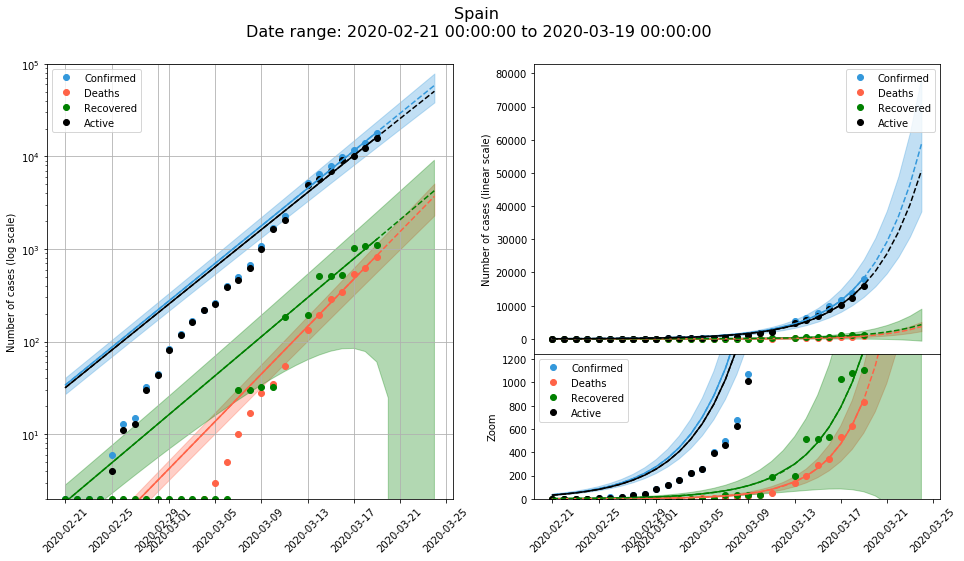

In [43]:
display(Markdown("## Spain"))
display(Markdown("I can see a change in the slope of the last few days. However, it is not clear if it is an exponential function with a different growth or the start of change to a logistic growth. I plot both of them. Exponential means worse news."))
display(Markdown("## Spain (exponential)"))
min_y1 = {'Confirmed': 1000, 'Deaths': 10, 'Recovered': 100}
fits_todo1 = {'Confirmed': [func_exponential],
             'Deaths':     [func_exponential],
             'Recovered':  [func_exponential]}
threshold1 = {'Confirmed': 0.9, 'Deaths': 0.8}

my_country = select_country(data, country='Spain', start_date='2020-02-21')
data_country, prediction = fit_data(my_country, min_y = min_y1, fits_todo=fits_todo1, threshold=threshold1)
fig, ax = plot_country(data_country, prediction)
print_prediction(prediction, days=5)

I can see a change in the slope of the last few days. However, it is not clear if it is an exponential function with a different growth or the start of change to a logistic growth. I plot both of them. Exponential means worse news.

## Spain (logistic)

#### 5 day prediction

,Date (end of),Confirmed,Deaths,Recovered
28,Friday 20 March 2020,19981,990,1623
29,Saturday 21 March 2020,22428,1150,2068
30,Sunday 22 March 2020,24608,1291,2634
31,Monday 23 March 2020,26470,1406,3355
32,Tuesday 24 March 2020,28004,1495,4273


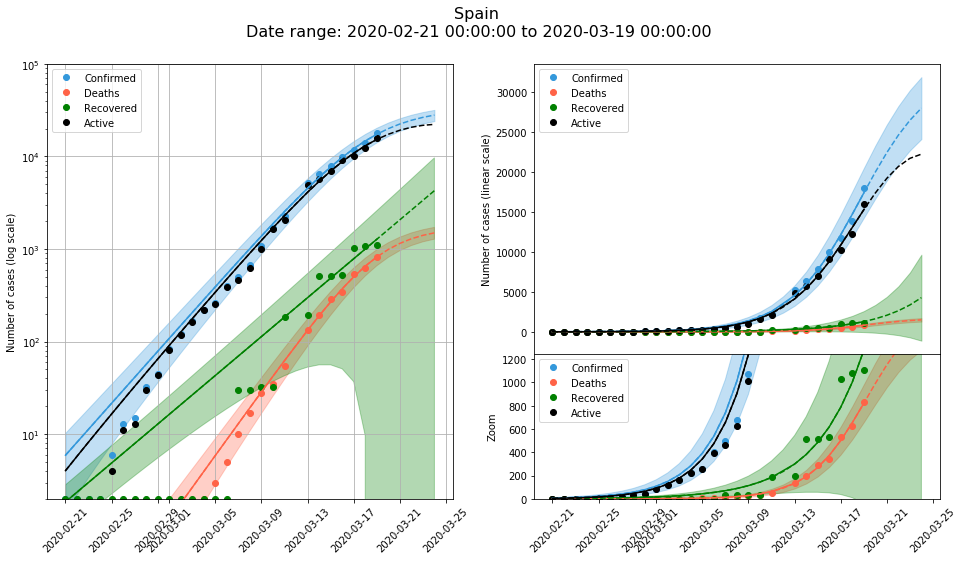

In [45]:
display(Markdown("I can see a change in the slope of the last few days. However, it is not clear if it is an exponential function with a different growth or the start of change to a logistic growth. I plot both of them. Exponential means worse news."))
display(Markdown("## Spain (logistic)"))
min_y1 = {'Confirmed': 100, 'Deaths': 10, 'Recovered': 100}
fits_todo1 = {'Confirmed': [func_exponential, func_logistic],
             'Deaths':     [func_exponential, func_logistic],
             'Recovered':  [func_exponential]}
threshold1 = {'Confirmed': 0.9, 'Deaths': 0.8}

my_country = select_country(data, country='Spain', start_date='2020-02-21')
data_country, prediction = fit_data(my_country, min_y = min_y1, fits_todo=fits_todo1, threshold=threshold1)
fig, ax = plot_country(data_country, prediction)
print_prediction(prediction, days=5)

## Italy

#### 5 day prediction

,Date (end of),Confirmed,Deaths,Recovered
28,Friday 20 March 2020,44581,3783,5497
29,Saturday 21 March 2020,48614,4162,6602
30,Sunday 22 March 2020,52436,4506,7930
31,Monday 23 March 2020,55980,4810,9523
32,Tuesday 24 March 2020,59204,5071,11438


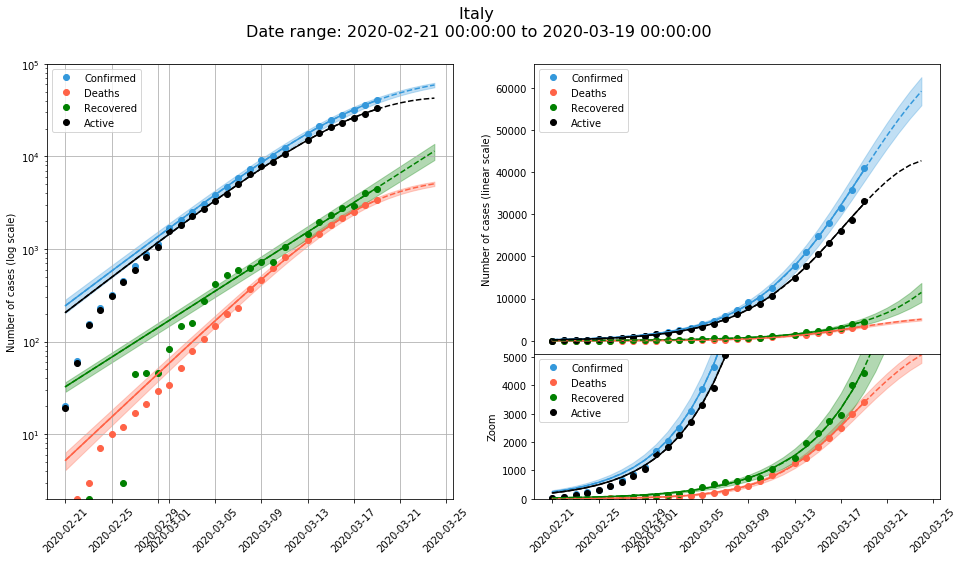

In [49]:
display(Markdown("## Italy"))
min_y1 = {'Confirmed': 10, 'Deaths': 1, 'Recovered': 10}
fits_todo1 = {'Confirmed': [func_exponential, func_logistic],
             'Deaths':     [func_exponential, func_logistic],
             'Recovered':  [func_exponential]}

my_country = select_country(data, country='Italy', start_date='2020-02-21')
data_country, prediction = fit_data(my_country, min_y = min_y1, fits_todo=fits_todo1)
fig, ax = plot_country(data_country, prediction)
print_prediction(prediction, days=5)

## France

#### 5 day prediction

,Date (end of),Confirmed,Deaths,Recovered
27,Friday 20 March 2020,13712,281,14
28,Saturday 21 March 2020,16819,347,14
29,Sunday 22 March 2020,20631,428,14
30,Monday 23 March 2020,25307,528,14
31,Tuesday 24 March 2020,31043,651,15


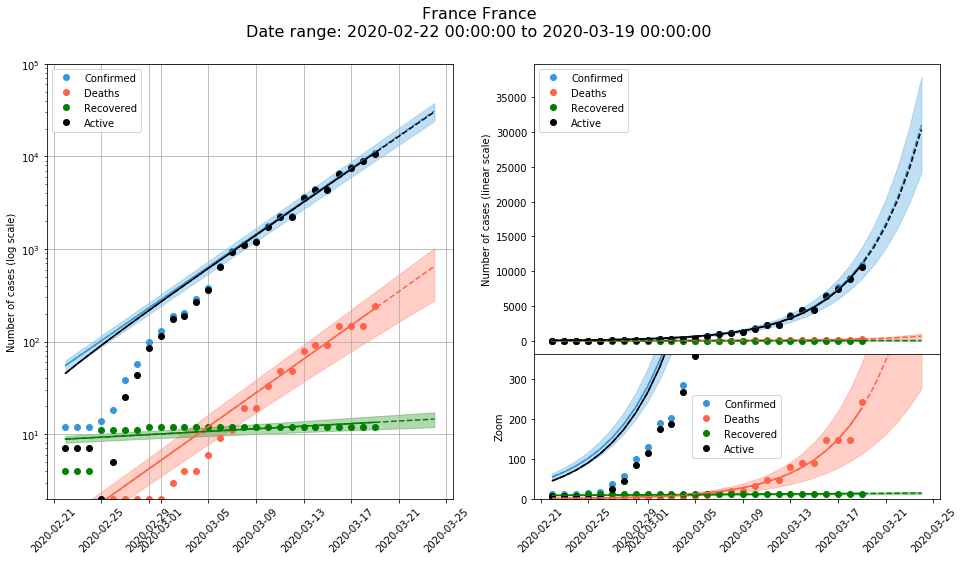

In [51]:
display(Markdown("## France"))
min_y1 = {'Confirmed': 50, 'Deaths': 10, 'Recovered': 2}

fits_todo1 = {'Confirmed': [func_exponential],
             'Deaths':     [func_exponential],
             'Recovered':  [func_exponential]}

threshold1 = {'Confirmed': 0.9, 'Deaths': 0.9}
my_country = select_country(data, country='France',province='France', start_date='2020-02-22')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1, threshold=threshold1)
fig, ax = plot_country(data_country, prediction)
print_prediction(prediction, days=5)

## Germany

#### 5 day prediction

,Date (end of),Confirmed,Deaths,Recovered
27,Friday 20 March 2020,19981,60,123
28,Saturday 21 March 2020,25729,83,142
29,Sunday 22 March 2020,33131,116,166
30,Monday 23 March 2020,42661,161,192
31,Tuesday 24 March 2020,54933,223,223


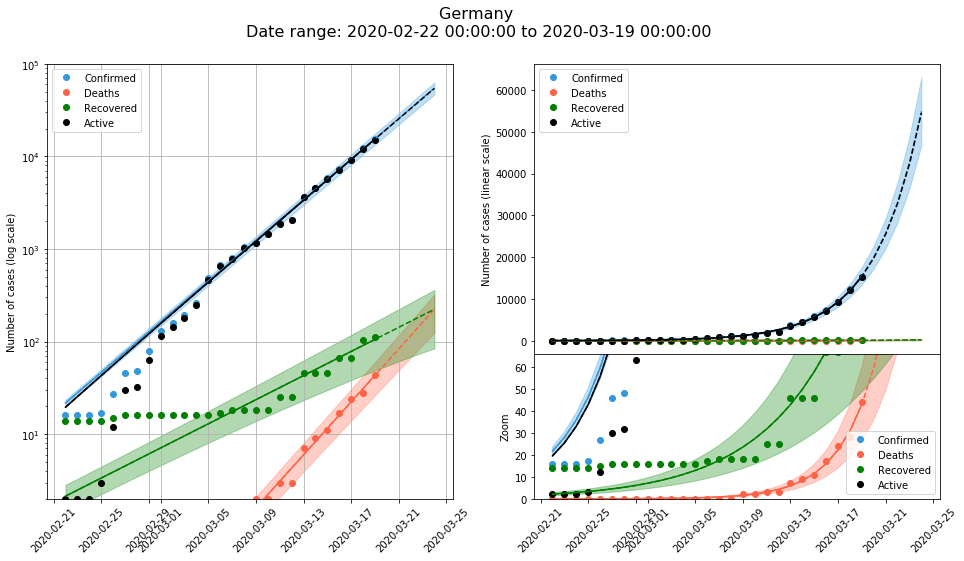

In [28]:
display(Markdown("## Germany"))
min_y1 = {'Confirmed': 50, 'Deaths': 2, 'Recovered': 20}

fits_todo1 = {'Confirmed': [func_exponential],
             'Deaths':     [func_exponential],
             'Recovered':  [func_exponential, func_logistic]}
threshold1 = {'Confirmed': 0.9, 'Deaths': 0.8}

my_country = select_country(data, country='Germany',province='', start_date='2020-02-22')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1, threshold=threshold1)
fig, ax = plot_country(data_country, prediction)
print_prediction(prediction, days=5)

## United Kingdom

#### 5 day prediction

,Date (end of),Confirmed,Deaths,Recovered
27,Friday 20 March 2020,3602,187,70
28,Saturday 21 March 2020,4446,272,80
29,Sunday 22 March 2020,5487,397,91
30,Monday 23 March 2020,6772,579,104
31,Tuesday 24 March 2020,8359,845,119


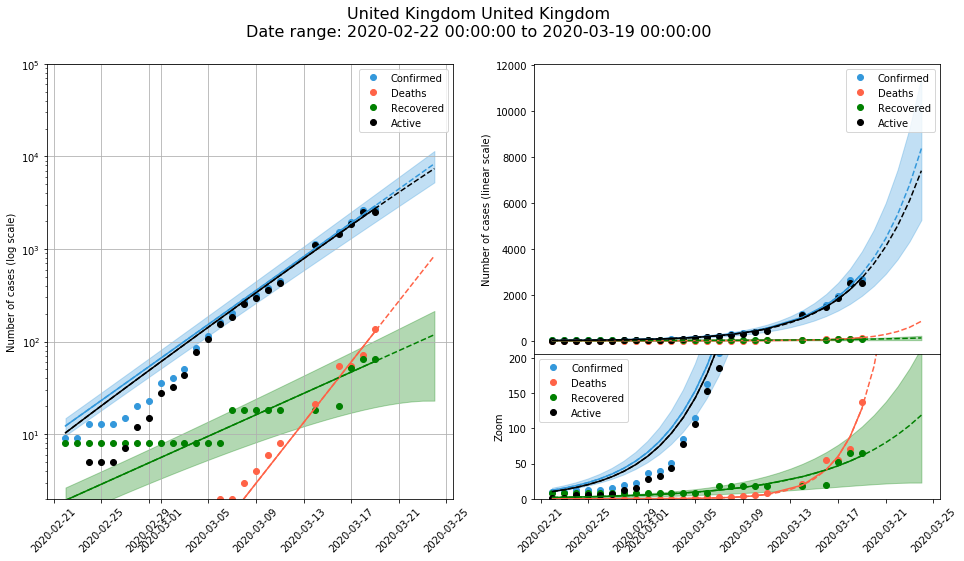

In [29]:
display(Markdown("## United Kingdom"))
min_y1 = {'Confirmed': 50, 'Deaths': 2, 'Recovered': 1}

fits_todo1 = {'Confirmed': [func_exponential],
             'Deaths':     [func_exponential],
             'Recovered':  [func_exponential]}

my_country = select_country(data, country='United Kingdom',province='United Kingdom', start_date='2020-02-22')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1)
fig, ax = plot_country(data_country, prediction)
print_prediction(prediction, days=5)

## Sweden

#### 5 day prediction

,Date (end of),Confirmed,Deaths,Recovered
27,Friday 20 March 2020,1406,12,nan
28,Saturday 21 March 2020,1434,13,nan
29,Sunday 22 March 2020,1455,13,nan
30,Monday 23 March 2020,1469,13,nan
31,Tuesday 24 March 2020,1479,14,nan


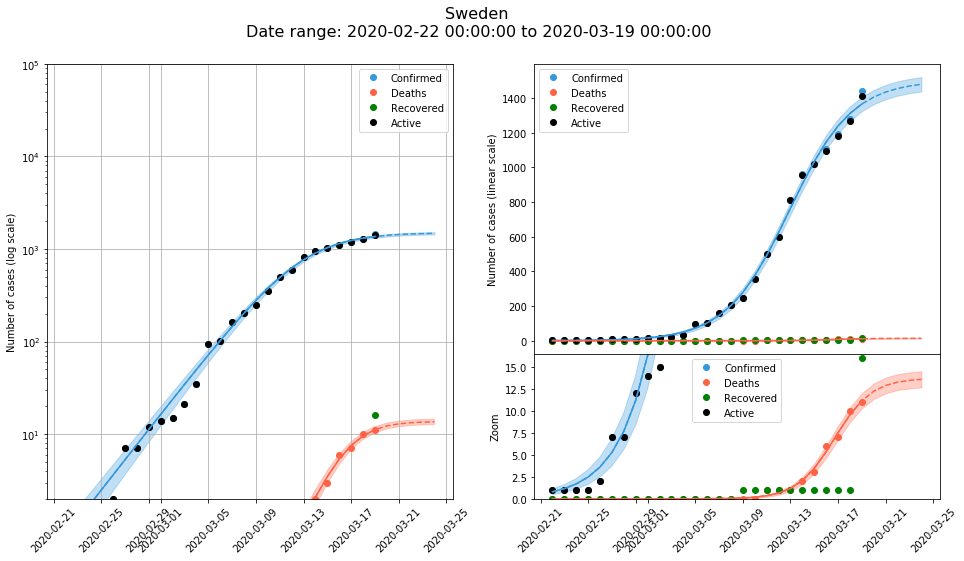

In [30]:
display(Markdown("## Sweden"))
min_y1 = {'Confirmed': 50, 'Deaths': 0, 'Recovered': 0}

fits_todo1 = {'Confirmed': [func_exponential, func_logistic],
             'Deaths':     [func_exponential, func_logistic],
             'Recovered':  [func_exponential, func_logistic]}
threshold1 = {'Confirmed': 0.6, 'Deaths': 0.6}

my_country = select_country(data, country='Sweden',province='', start_date='2020-02-22')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1, threshold=threshold1)
fig, ax = plot_country(data_country, prediction)
print_prediction(prediction, days=5)

## Netherlands

#### 5 day prediction

,Date (end of),Confirmed,Deaths,Recovered
27,Friday 20 March 2020,3096,110,nan
28,Saturday 21 March 2020,3799,155,nan
29,Sunday 22 March 2020,4661,218,nan
30,Monday 23 March 2020,5719,307,nan
31,Tuesday 24 March 2020,7018,432,nan


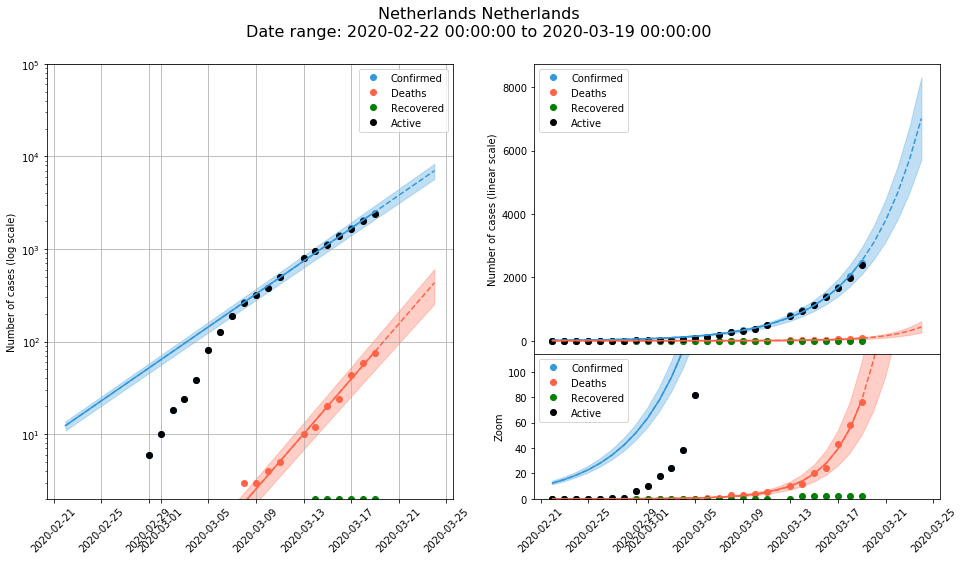

In [31]:
display(Markdown("## Netherlands"))
min_y1 = {'Confirmed': 10, 'Deaths': 4, 'Recovered': 0}
do_debug=False
fits_todo1 = {'Confirmed': [func_exponential],
             'Deaths':     [func_exponential],
             'Recovered':  [func_exponential, func_logistic]}

my_country = select_country(data, country='Netherlands',province='Netherlands', start_date='2020-02-22')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1)
fig, ax = plot_country(data_country, prediction)
print_prediction(prediction, days=5)


## Poland

#### 5 day prediction

,Date (end of),Confirmed,Deaths,Recovered
27,Friday 20 March 2020,470,8,nan
28,Saturday 21 March 2020,615,10,nan
29,Sunday 22 March 2020,806,12,nan
30,Monday 23 March 2020,1056,15,nan
31,Tuesday 24 March 2020,1383,18,nan


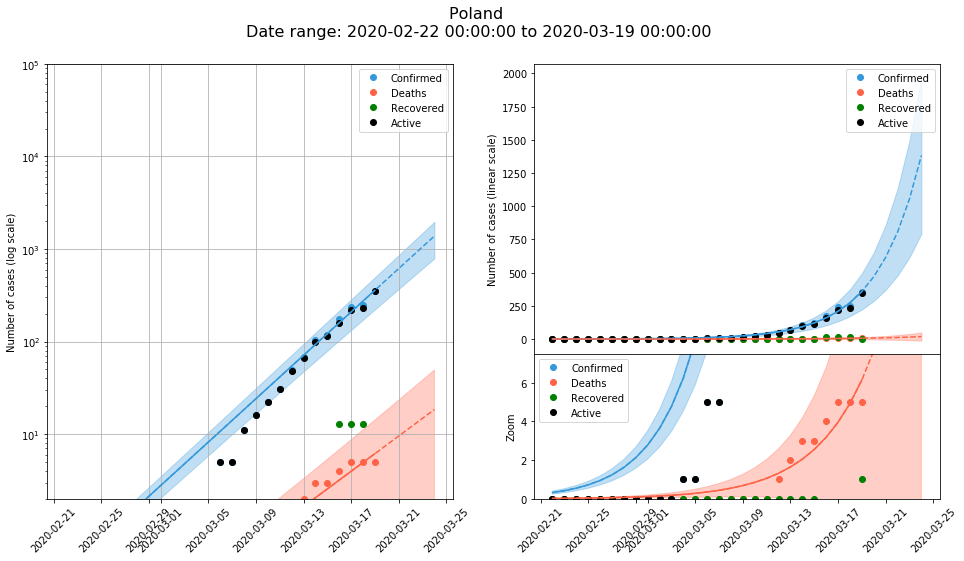

In [32]:
display(Markdown("## Poland"))
min_y1 = {'Confirmed': 10, 'Deaths': 1, 'Recovered': 0}
do_debug=False
fits_todo1 = {'Confirmed': [func_exponential],
             'Deaths':     [func_exponential],
             'Recovered':  [func_exponential, func_logistic]}

my_country = select_country(data, country='Poland',province='', start_date='2020-02-22')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1)
fig, ax = plot_country(data_country, prediction)
print_prediction(prediction, days=5)


# United States

I use the combined data for all the states combined

#### 5 day prediction

,Date (end of),Confirmed,Deaths,Recovered
24,Friday 20 March 2020,17622,223,10
25,Saturday 21 March 2020,24418,281,10
26,Sunday 22 March 2020,33836,353,10
27,Monday 23 March 2020,46887,444,11
28,Tuesday 24 March 2020,64971,558,11


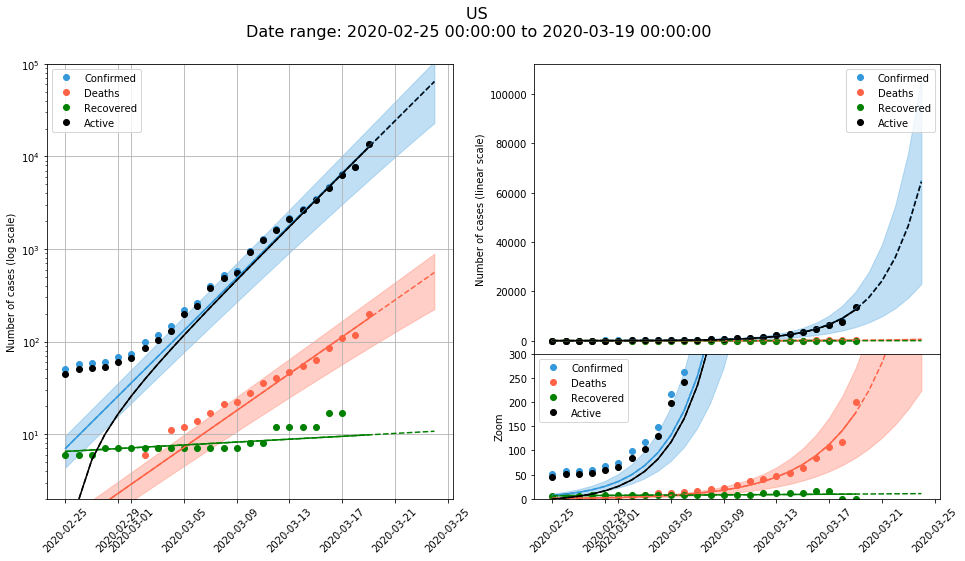

In [33]:
per_country = data.groupby(['DateTime','Country/Region']).sum().reset_index()
usa = per_country[per_country['Country/Region']=='US']
usa['Province/State'] = ''
min_y1 = {'Confirmed': 50, 'Deaths': 0, 'Recovered': 0}
fits_todo1 = {'Confirmed': [func_exponential],
             'Deaths':     [func_exponential],
             'Recovered':  [func_exponential]}

my_country = select_country(usa, country='US', province='', start_date='2020-02-25')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1)
fig, ax = plot_country(data_country, prediction)
print_prediction(prediction, days=5)

# Comparison of different countries, with a manual time delay to align them

In [34]:
def compare_countries2(data, countries, lw1=4, name='comparison'):
    gridsize = (3, 2)
    fig = plt.figure(figsize=(12, 10))
    ax1 = plt.subplot2grid(gridsize, (0, 0))
    ax2 = plt.subplot2grid(gridsize, (1, 0))
    ax3 = plt.subplot2grid(gridsize, (2, 0))
    #ax4 = plt.subplot2grid(gridsize, (3, 0))
    ax1b = plt.subplot2grid(gridsize, (0, 1))
    ax2b = plt.subplot2grid(gridsize, (1, 1))
    ax3b = plt.subplot2grid(gridsize, (2, 1))
    #ax4b = plt.subplot2grid(gridsize, (3, 1))
    plt.subplots_adjust(hspace=0)

    for country in countries.keys():
        c = countries[country]
        my_country = select_country(data,
                                    country=c['country'],
                                    province=c.get('province', ''),
                                    start_date=c.get('start_date', '2020-02-15'),
                                    end_date=c.get('end_date', '2021-01-01'))
        data_country1, prediction1 = fit_data(my_country)

        symbol='x'
        l = ax1.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Confirmed'], symbol)
        l = ax1.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Confirmed_fit'], '-', color=l[0].get_color(), lw=lw1, label=f'{country} ({c["delay"]}d)')
        l = ax1.plot(prediction1['DateTime']  +datetime.timedelta(days=c['delay']), prediction1['Confirmed_pred'], '--', color=l[0].get_color())
        l = ax2.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Deaths'], symbol)
        l = ax2.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Deaths_fit'], '-', color=l[0].get_color(), lw=lw1, label=f'{country} ({c["delay"]}d)')
        l = ax2.plot(prediction1['DateTime']  +datetime.timedelta(days=c['delay']), prediction1['Deaths_pred'], '--', color=l[0].get_color())
        l = ax3.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Recovered'], symbol)
        l = ax3.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Recovered_fit'], '-', color=l[0].get_color(), lw=lw1, label=f'{country} ({c["delay"]}d)')
        l = ax3.plot(prediction1['DateTime']  +datetime.timedelta(days=c['delay']), prediction1['Recovered_pred'], '--', color=l[0].get_color())
        
        l = ax1b.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Confirmed'], symbol)
        l = ax1b.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Confirmed_fit'], '-', color=l[0].get_color(), lw=lw1, label=f'{country} ({c["delay"]}d)')
        l = ax1b.plot(prediction1['DateTime']  +datetime.timedelta(days=c['delay']), prediction1['Confirmed_pred'], '--', color=l[0].get_color())
        l = ax2b.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Deaths'], symbol)
        l = ax2b.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Deaths_fit'], '-', color=l[0].get_color(), lw=lw1, label=f'{country} ({c["delay"]}d)')
        l = ax2b.plot(prediction1['DateTime']  +datetime.timedelta(days=c['delay']), prediction1['Deaths_pred'], '--', color=l[0].get_color())
        l = ax3b.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Recovered'], symbol)
        l = ax3b.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Recovered_fit'], '-', color=l[0].get_color(), lw=lw1, label=f'{country} ({c["delay"]}d)')
        l = ax3b.plot(prediction1['DateTime']  +datetime.timedelta(days=c['delay']), prediction1['Recovered_pred'], '--', color=l[0].get_color())
       
        
    #ax3.set_ylim(0, np.max(data_country['Deaths'])*1.5)
    #ax2.set_ylim(0,1e5)
    #ax1.set_ylim(0.5,1e5)

    ax1.set_ylabel('Confirmed')
    ax2.set_ylabel('Deaths')
    ax3.set_ylabel('Recovered')
    
    for ax in [ax1,ax2,ax1b,ax2b]:
        ax.xaxis.set_ticklabels([])
    ax3.xaxis.set_tick_params(rotation=45)
    ax3b.xaxis.set_tick_params(rotation=45)
    ax1.set_title('Log scale')
    ax1b.set_title('Linear scale')
    #fig.suptitle(f'{country} {province}\nDate range: {start_date} to {end_date}', fontsize=16)

    for ax in [ax1,ax2,ax3]:
        ax.set_yscale('log')
    
    for ax in [ax1,ax2,ax3,ax1b,ax2b,ax3b]:
        ax.set_ylim(0.5,)
        ax.legend()
        
    fig.savefig(f'./plots/{name}.png', bbox_inches='tight', dpi=100)
        

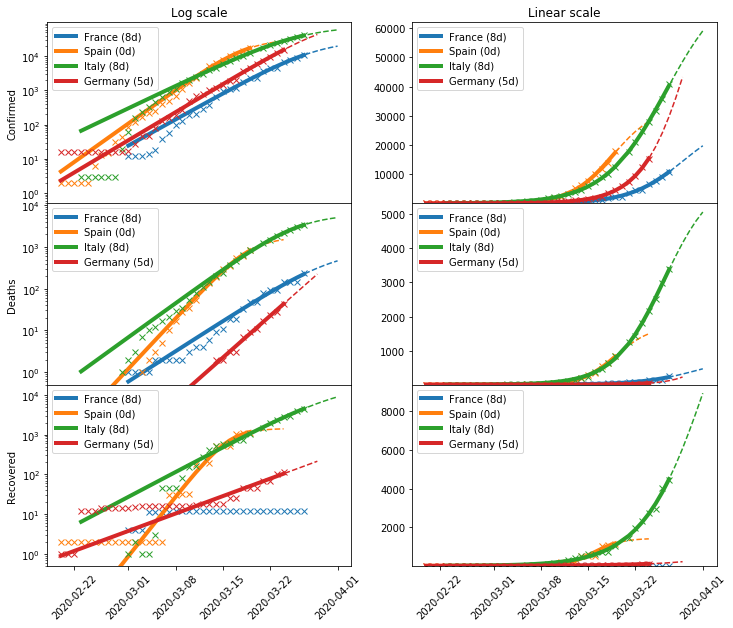

In [35]:
countries = {
    'France': {'country': 'France', 'province': 'France', 'start_date':'2020-02-22', 'end_date':'2021-01-01', 'delay': 8},
    'Spain': {'country': 'Spain', 'start_date':'2020-02-20', 'end_date':'2021-01-01', 'delay': 0},
    'Italy': {'country': 'Italy', 'start_date':'2020-02-15', 'end_date':'2021-01-01', 'delay': 8},
    'Germany': {'country': 'Germany', 'start_date':'2020-02-15', 'end_date':'2021-01-01', 'delay': 5},

}
compare_countries2(data, countries, name='comparison1')

## Early onset: China regions

Most of the regions have almost completed the cycle and active cases are disappearing. Note that China Hubei (the original area) has a large number of confirmed cases (70000), but the other regions have very low number of cases, with number around 1200-500 or even less.

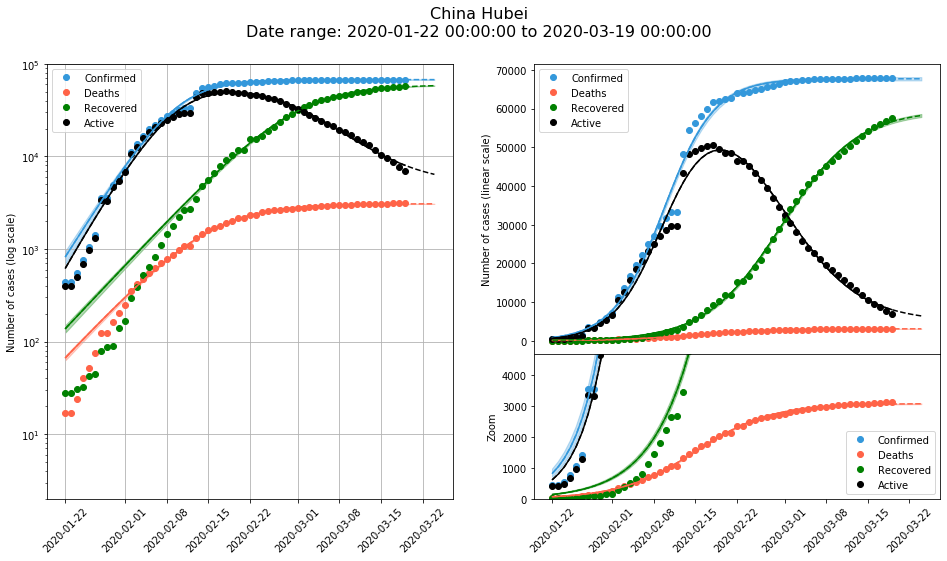

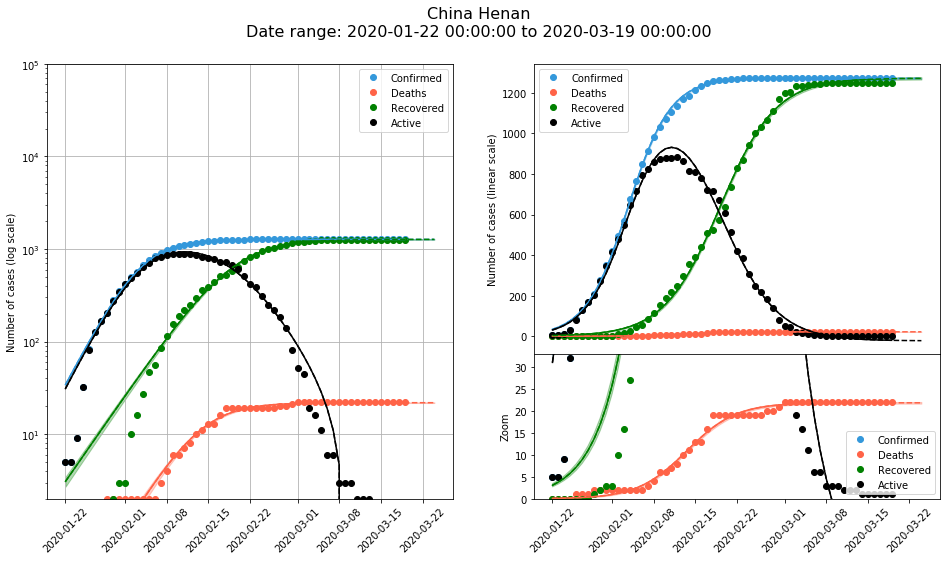

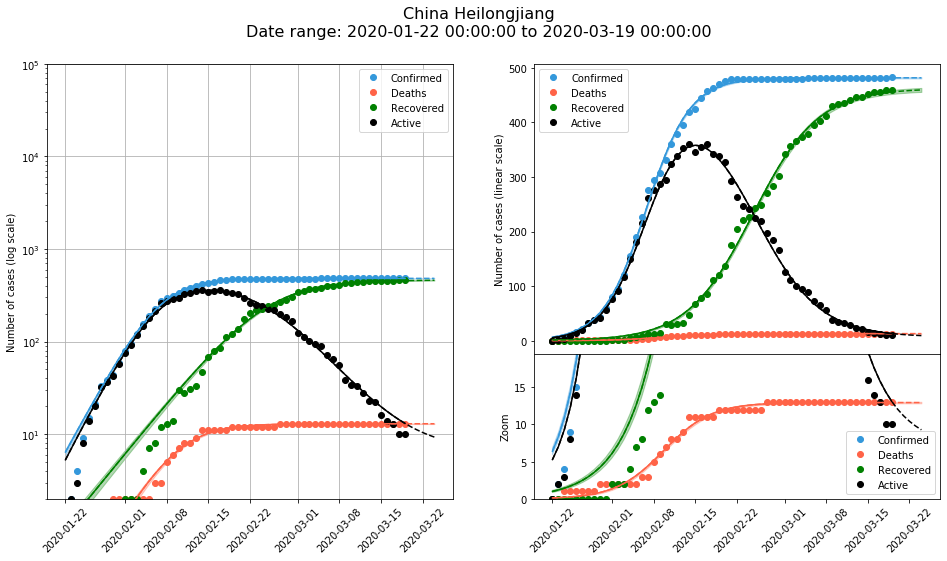

In [36]:
idx = data.groupby(['Country/Region', 'Province/State'])[['Confirmed','Deaths']].sum().sort_values(by='Deaths')[::-1][0:10].index
for i in idx:
    country, province = i
    if country == 'China':
        data_country, prediction, fig, ax = process_country(data, country=country, province=province, start_date='2020-01-01')

## Other countries in Asia

South Korea has a remarkable recovery rate, with many cases and a reduced number of deaths. Japan growth is moderate, much smaller than in European countries. Iran is showing hints of flattening, although it is curious that the number of recoveries has significantly slowed down while the number of deaths still follow a very exponential trend.


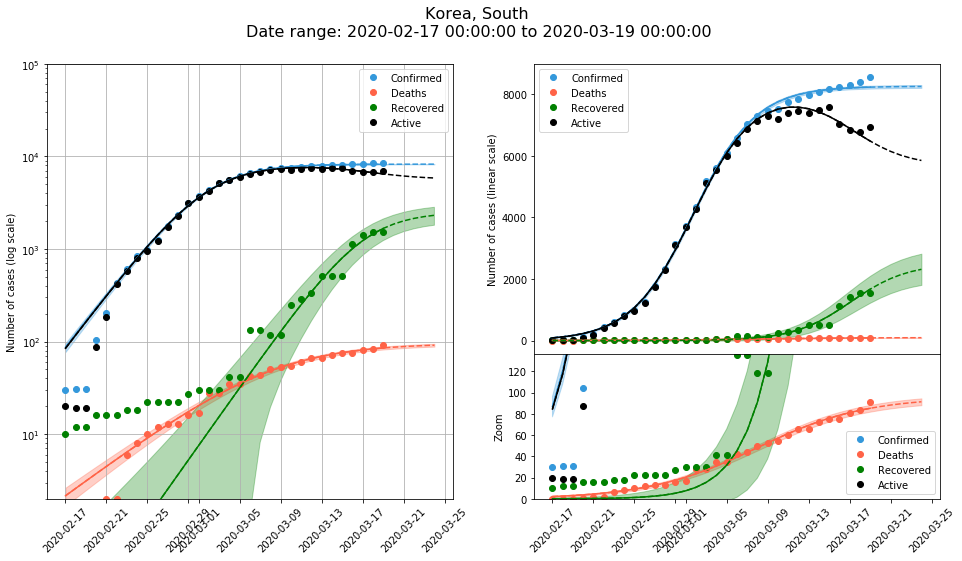

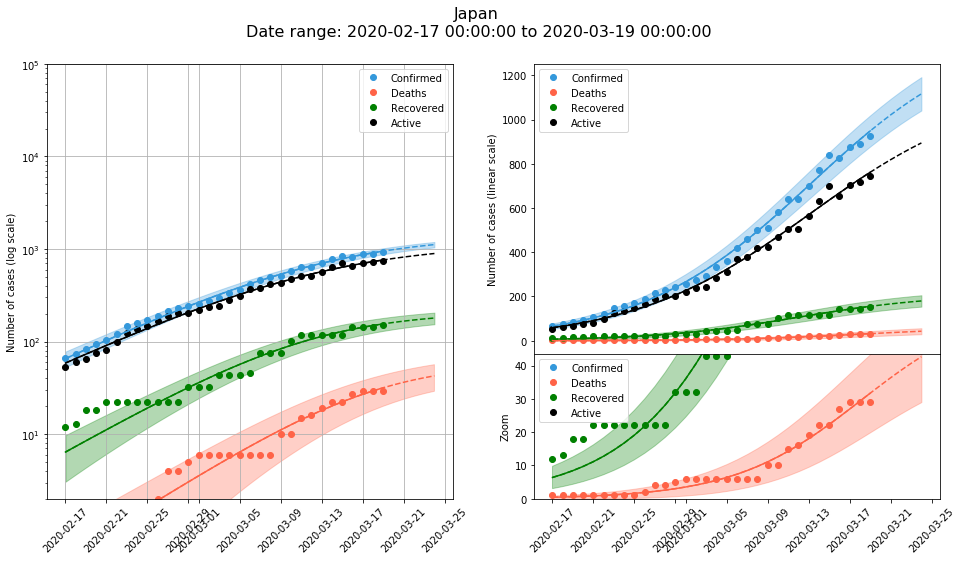

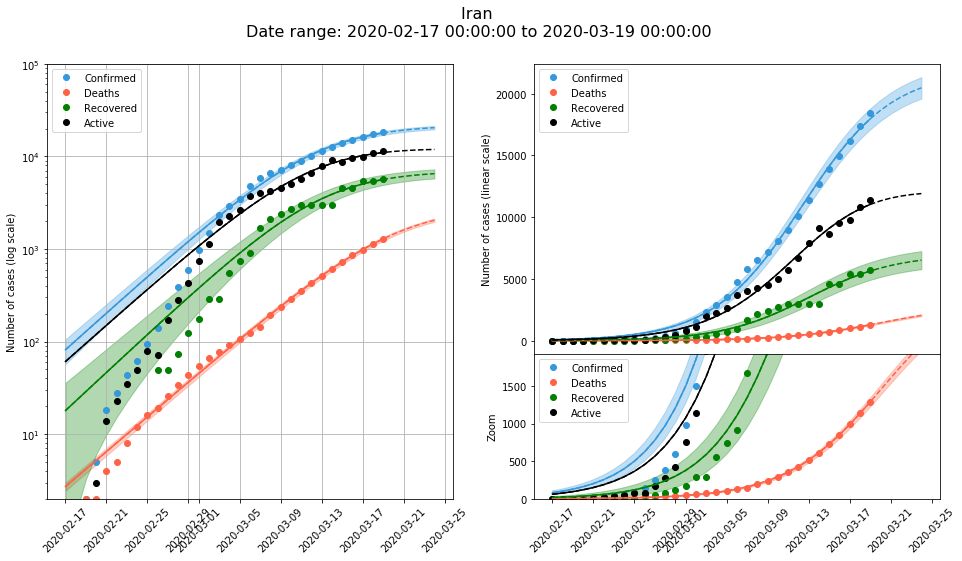

In [37]:
europe_list = [
    ['Korea, South', ''],
    ['Japan', ''],
    ['Iran', '']
]
for country, province in europe_list:
    data_country, prediction, fig, ax = process_country(data, country=country, province=province, start_date='2020-02-17')